## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/feature-selection-why-how-explained-part-2-352d9130c2e1)) <font size='3ptx'>**Feature selection algorithm implementations in Python**</font>

In the last article, I explained the problems with including irrelevant or correlated features in model building. **In this article, I’ll show you several neat implementations of selection algorithms that can be easily integrated into your project pipeline.**

Before diving into the detailed implementation, let’s go through the dataset I created. **The dataset has 20 features, among which <font color='red'>5 contribute to the output</font> and 2 are correlated.**

In [70]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import GenericUnivariateSelect as GUS, f_classif, chi2
from sklearn.linear_model import LassoCV

RANDOM_STATE = 42
X, y = make_classification(n_samples=1000, n_features=20, n_informative=5, n_redundant=2, n_classes=4)

In [2]:
X.shape

(1000, 20)

In [3]:
y.shape

(1000,)

## <font color='darkblue'>1. Wrapper Feature Selection</font>
<font size='3ptx'>**Detection Ability: ★★★★☆ Speed: ★☆☆☆☆**</font>

Wrapper algorithms are straightforward. **The validity of features is examined by training and validating models. That means wrappers are <font color='darkred'>very slow when it comes to large datasets</font>**.

![1.png](images/1.png)
<br/>

Though the specific criteria for adding/dropping features might differ, the core ideas are the same. Therefore, I’ll focus on one particular method called <font color='darkblue'>**Backward Selection**</font>.

### <font color='darkgreen'>1.1. Wrapper Algorithm: Backward Selection</font>
Provided with a model that has feature coefficients (<font color='brown'>e.g. regression</font>)or importance factors (<font>e.g. trees</font>), the algorithm starts from all features and greedily eliminates the least important feature. Once all features are removed, the algorithm returns the subset which gives the best performance.

### <font color='darkgreen'>1.2. Backward selection in Python</font>
Scikit-Learn provides a nice implementation called [**RFECV**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) (<font color='brown'>Recursive Feature Elimination and Cross-Validation Selection</font>), an algorithm eliminates irrelevant features based on validation scores.

RFE needs several parameters and you must provide these two:
* **estimator (object):** A supervised learning estimator with a `fit` method that provides information about feature importance either through <font color='violet'>coef_</font> or <font color='violet'>feature_importances_</font>
* **scoring:** string, callable or None, optional, (<font color='brown'>default=None</font>)

There are many estimators in Scikit-Learn satisfy the criteria. In this example, a simple [**SVM classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) is used. A scoring function is a metric to evaluate the performance of the model (<font color='brown'>e.g. accuracy</font>).

In [4]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    svc = LinearSVC() #estimator
    rfecv = RFECV(estimator=svc, scoring='accuracy')
    rfecv.fit(X, y)
    
rfecv.support_

Wall time: 37 s


In [5]:
# Feature importance ranking
rfecv.ranking_

array([ 8,  4,  6,  1,  1, 15,  5,  3, 11, 16,  7,  1,  9,  1,  2, 13,  1,
       12, 14, 10])

In [6]:
len(list(filter(lambda e: e, rfecv.support_)))

5

In [97]:
feat_acc_pairs = []
def get_required_num_feature(num_feat, rfecv=rfecv, scoring='accuracy'):
    column_selection = [rfecv.ranking_[i]<=num_feat for i in range(X.shape[1])]
    return X[:, column_selection]

svc = SVC()
for i in range(2, X.shape[1]+1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        X_sub = get_required_num_feature(i)
        X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.33, random_state=RANDOM_STATE)
        svc.fit(X_train, y_train)
        feat_acc_pairs.append((i, svc.score(X_test, y_test)))

In [98]:
feat_acc_pairs

[(2, 0.5181818181818182),
 (3, 0.48787878787878786),
 (4, 0.49393939393939396),
 (5, 0.49393939393939396),
 (6, 0.5909090909090909),
 (7, 0.6181818181818182),
 (8, 0.6090909090909091),
 (9, 0.6),
 (10, 0.6090909090909091),
 (11, 0.6636363636363637),
 (12, 0.6575757575757576),
 (13, 0.6484848484848484),
 (14, 0.6545454545454545),
 (15, 0.6454545454545455),
 (16, 0.8090909090909091),
 (17, 0.8090909090909091),
 (18, 0.8090909090909091),
 (19, 0.8090909090909091),
 (20, 0.8090909090909091)]

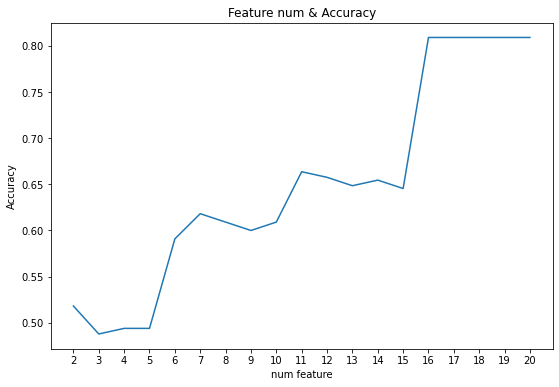

In [99]:
plt.rcParams['figure.figsize'] = [9, 6]
x_axis = list(map(lambda t: t[0], feat_acc_pairs))
y_axis = list(map(lambda t: t[1], feat_acc_pairs))         
plt.plot(x_axis, y_axis)  
plt.xlabel('num feature')  
plt.ylabel('Accuracy')
plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1))
plt.title("Feature num & Accuracy")
plt.show()  

[**RFECV**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) selects 6 features, including all relevant features and redundant features. **This shows that RFECV isn’t good at removing multicollinearity** (<font color='brown'>since the coefficients of colinear features tend to vary widely</font>). Therefore, it is a good practice to identify multicollinearity first (<font color='brown'>e.g. [using condition number](https://medium.com/@zhangzix/feature-selection-why-how-explained-part-1-c2f638d24cdb)</font>).

## <font color='darkblue'>2. Filtering Feature Selection</font>
<font size='3ptx'>**Detection Ability: ★★☆☆☆ Speed: ★★★★★**</font>

**In real-world applications where millions of data points are used, wrappers become impractical**. **<font color='darkblue'>Filtering algorithms</font> approach the problem by estimating the validities of features through statistical tests** (<font color='brown'>e.g. correlation coefficient</font>) instead of training an actual model.

Although there are many advanced filtering methods such as mRMR, I prefer this straightforward two-step method.
![2.png](images/2.png)
<br/>

### <font color='darkgreen'>2.1. Remove Correlated Features: Condition Number</font>
As introduced in the first article, colinearity or multicollinearity is harmful. Following is an algorithm developed by myself to eliminate both.
![3.png](images/3.png)
[“Revisiting the Collinear Data Problem: An Assesment of Estimator ‘Ill-Conditioning’ in Linear Regression”](https://pareonline.net/getvn.asp?v=13&n=5)

<br/>

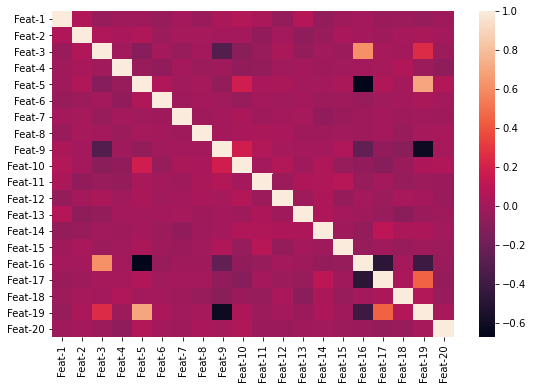

In [100]:
# https://datatofish.com/correlation-matrix-pandas/
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(X, columns=[f"Feat-{i+1}" for i in range(X.shape[1])])

corrMatrix = df.corr()
sn.heatmap(corrMatrix)
plt.show()

In [101]:
import numpy as np
def condition_number(corr):# corr: correlation matrix
    eigValues, eigVectors = np.linalg.eig(corr) 
    return abs(max(eigValues)/min(eigValues))

# greadily kick out the worst feature    
def eliminate_multicol(X, threshold = 100):#weak corr threshold
    corr = np.corrcoef(X.T) # get corr matrix
    if (condition_number(corr) < threshold or X.shape[1]<=1):
        return X  
    
    # find the feature with highest corr coef(lower triangle)
    mostCorrelated = np.argmax([max(corr[i+1:,i]) for i in range(X.shape[1]-1)] )
    choose = [True]*X.shape[1]
    choose[mostCorrelated] = False # kick that feature out
    return eliminate_multicol(X[:,choose])

### <font color='darkgreen'>2.2. Remove Irrelevant Features: Univariate Selection</font>
Univariate selection performs statistical tests on features and the output and only features with high scores are kept. Common tests include [**Chi-Square**](https://en.wikipedia.org/wiki/Chi-squared_test), [**ANOVA**](https://en.wikipedia.org/wiki/Analysis_of_variance), or [**Mutual Information**](https://en.wikipedia.org/wiki/Mutual_information).

Again, Scikit-Learn offers a nice function called [**GenericUnivariateSelect**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html). This function needs 3 parameters:
* **score_func (callable):** Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues). For modes ‘percentile’ or ‘kbest’ it can return a single array scores.
* **mode:** {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}
* **param:** float or int depending on the feature selection mode

Choose your desired statistic methods (<font color='brown'>e.g. Chi-Square, F score</font>) as the scoring function. I’ll use [**f_classif**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) (<font color='brown'>ANOVA F-value between label/feature for classification tasks.</font>) since `y` is categorical.

In [102]:
X.shape

(1000, 20)

In [103]:
%time
X_remove_multicol = eliminate_multicol(X) # remove multicollinearity
X_remove_multicol.shape

Wall time: 0 ns


(1000, 18)

In [104]:
gus = GUS (f_classif, 'fwe', param=0.4) # keep features with P < 0.4
X_new = gus.fit_transform(X_remove_multicol, y) # remove irrelevant features

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass mode=fwe as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [105]:
X_new.shape

(1000, 6)

The algorithm drops features with `P` values greater than 0.4. It is a good practice to use threshold not too small so that we don’t drop informative features(<font color='brown'>we dropped a useful feature here</font>).

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=RANDOM_STATE)
svc.fit(X_train, y_train)
default_svc_accuracy = svc.score(X_test, y_test)
print(f"Obtained accuracy={default_svc_accuracy:.02f}")

Obtained accuracy=0.83


## <font color='darkblue'>3. Embedded Feature Selection</font>
<font size='3ptx'>**Detection Ability: ★★★☆☆ Speed: ★★★☆☆**</font>

<font color='darkblue'>**Embedded feature selection**</font> intelligently drops unnecessary features during training. Common algorithms include Lasso regression, decision tree, and auto-encoder neural network. I’ll explain Lasso regression here.

### <font color='darkgreen'>3.1. Embedded Algorithm: Lasso regression</font>
![4.png](images/4.png)
<br/>
Lasso regression penalizes the model for using large feature weights/too many features. **As a result, the model tends to use as few parameters as possible and therefore produces sparse results** (<font color='brown'>i.e. some features have weight 0</font>).

### <font color='darkgreen'>3.2. Lasso Regression in Python</font>
As usual, you can find lasso regression [**LassoCV**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) in Scikit-Learn. When initializing the model, the only parameter that you must provide is Alpha, which determines the strength of the penalty. **Larger alpha leads to sparser results and alpha=0 essentially means no lasso penalty**:

In [59]:
%time
def num_of_selected_feat(lassoModel):
    feature_selection = list(map(lambda e: abs(e) > 0, lassoModel.coef_))
    return len(list(filter(lambda e: e, feature_selection)))

# import lasso with cross validation
alpha_num_feats = []
for ets_as_log in range(-10, 1):
    lassoModel = LassoCV(eps=pow(10, ets_as_log), cv=5, random_state=RANDOM_STATE).fit(X,y)
    alpha_num_feats.append((ets_as_log, num_of_selected_feat(lassoModel)))

Wall time: 0 ns


In [60]:
lassoModel.coef_

array([-0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,
       -0., -0., -0., -0.,  0., -0., -0.])

In [61]:
feature_selection = list(map(lambda e: abs(e) > 0, lassoModel.coef_))
feature_selection[:5]

[False, False, False, False, False]

In [62]:
alpha_num_feats

[(-10, 7),
 (-9, 6),
 (-8, 6),
 (-7, 6),
 (-6, 6),
 (-5, 7),
 (-4, 6),
 (-3, 6),
 (-2, 6),
 (-1, 5),
 (0, 0)]

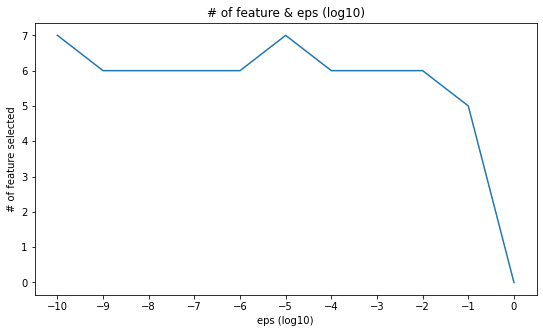

In [63]:
plt.rcParams['figure.figsize'] = [9, 5]
x_axis = list(map(lambda t: t[0], alpha_num_feats))
y_axis = list(map(lambda t: t[1], alpha_num_feats))         
plt.plot(x_axis, y_axis)  
plt.xlabel('eps (log10)')  
plt.ylabel('# of feature selected')
plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1))
plt.title("# of feature & eps (log10)")
plt.show()  

In [113]:
lassoModel = LassoCV(eps=pow(10, -4), cv=5, random_state=RANDOM_STATE).fit(X, y)
feature_selection = list(map(lambda e: abs(e) > 0, lassoModel.coef_))
X_selected = X[:, feature_selection]
X_selected.shape

(1000, 8)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=RANDOM_STATE)
svc.fit(X_train, y_train)
default_svc_accuracy = svc.score(X_test, y_test)
print(f"Obtained accuracy={default_svc_accuracy:.02f}")

Obtained accuracy=0.84


## <font color='darkblue'>4. Auto-Encoder</font>
For Keras Auto-Encoder, you can refer to [this post "**Building Autoencoders in Keras**"](https://blog.keras.io/building-autoencoders-in-keras.html) for more details:
> "Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

![auto-encoder](http://localhost/JJWiki/attach/ML%20IH/4110_3.PNG)

In [52]:
import keras
from keras.models import Model
from keras import layers

def get_auto_encoder_model(encoding_dim, input_dim=X.shape[1]):
    # This is our input layer
    input_layer = keras.Input(shape=(input_dim,))

    hidden_layer1 = layers.Dense((input_dim+encoding_dim)//2, activation='relu')(input_layer)
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(hidden_layer1)

    hidden_layer2 = layers.Dense((input_dim+encoding_dim)//2, activation='relu')(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(input_dim, activation='sigmoid')(hidden_layer2)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')    
    return autoencoder, encoder

autoencoder, encoder = get_auto_encoder_model(encoding_dim=10)
autoencoder.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_41 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_42 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_43 (Dense)             (None, 20)                320       
Total params: 960
Trainable params: 960
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = autoencoder.fit(X, X, epochs=20)

Epoch 1/20
32/32 [==============================] - 0s 5ms/step - loss: 1.4364
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4354
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4346
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4342
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 1.4328
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4322
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4312
Epoch 8/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4305
Epoch 9/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4299
Epoch 10/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4295
Epoch 11/20
32/32 [==============================] - 0s 5ms/step - loss: 1.4288
Epoch 12/20
32/32 [==============================] - 0s 6ms/step - loss: 1.4277
Epoch 13/20
32/32 [==============================

In [45]:
X_encoded = encoder.predict(X)
X_encoded.shape

(1000, 10)

In [79]:
# Default accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)
svc.fit(X_train, y_train)
default_svc_accuracy = svc.score(X_test, y_test)
print(f"Default accuracy={default_svc_accuracy:.02f}")

Default accuracy=0.81


In [93]:
%%time
num_feature_accuracy = []
for num_feat in range(2, X.shape[1]+1, 2):
    autoencoder, encoder = get_auto_encoder_model(encoding_dim=num_feat)
    history = autoencoder.fit(X, X, epochs=30)
    X_encoded = encoder.predict(X)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=RANDOM_STATE)
    svc.fit(X_train, y_train)
    num_feature_accuracy.append((num_feat, svc.score(X_test, y_test)))

Epoch 1/30
32/32 [==============================] - 0s 5ms/step - loss: 2.1059
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 2.0742
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 2.0195
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 1.9338
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 1.8386
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 1.7756
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 1.7487
Epoch 8/30
32/32 [==============================] - 0s 6ms/step - loss: 1.7341
Epoch 9/30
32/32 [==============================] - 0s 5ms/step - loss: 1.7224
Epoch 10/30
32/32 [==============================] - 0s 6ms/step - loss: 1.7098
Epoch 11/30
32/32 [==============================] - 0s 6ms/step - loss: 1.6974
Epoch 12/30
32/32 [==============================] - 0s 5ms/step - loss: 1.6859
Epoch 13/30
32/32 [==============================

32/32 [==============================] - 0s 6ms/step - loss: 1.5527
Epoch 14/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5468
Epoch 15/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5419
Epoch 16/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5376
Epoch 17/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5337
Epoch 18/30
32/32 [==============================] - 0s 6ms/step - loss: 1.5301
Epoch 19/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5263
Epoch 20/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5228
Epoch 21/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5193
Epoch 22/30
32/32 [==============================] - 0s 5ms/step - loss: 1.5158
Epoch 23/30
32/32 [==============================] - 0s 6ms/step - loss: 1.5126
Epoch 24/30
32/32 [==============================] - 0s 6ms/step - loss: 1.5092
Epoch 25/30
32/32 [==============================] -

32/32 [==============================] - 0s 5ms/step - loss: 1.4827
Epoch 26/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4790
Epoch 27/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4760
Epoch 28/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4733
Epoch 29/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4705
Epoch 30/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4682
Epoch 1/30
32/32 [==============================] - 0s 5ms/step - loss: 2.1039
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 2.0266
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 1.9071
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 1.7693
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 1.6837
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 1.6353
Epoch 7/30
32/32 [==============================] - 0s 5ms

In [94]:
num_feature_accuracy

[(2, 0.4818181818181818),
 (4, 0.6696969696969697),
 (6, 0.7333333333333333),
 (8, 0.7121212121212122),
 (10, 0.703030303030303),
 (12, 0.7787878787878788),
 (14, 0.7727272727272727),
 (16, 0.7515151515151515),
 (18, 0.7424242424242424),
 (20, 0.7333333333333333)]

In [95]:
# Best performance from # of feature
sorted(num_feature_accuracy, key=lambda t: t[1], reverse=True)[0][0]

12

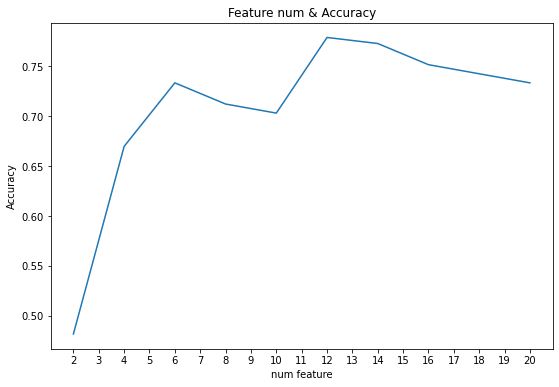

In [96]:
plt.rcParams['figure.figsize'] = [9, 6]
x_axis = list(map(lambda t: t[0], num_feature_accuracy))
y_axis = list(map(lambda t: t[1], num_feature_accuracy))         
plt.plot(x_axis, y_axis)  
plt.xlabel('num feature')  
plt.ylabel('Accuracy')
plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1))
plt.title("Feature num & Accuracy")
plt.show()  

## <font color='darkblue'>Summary</font>
Every type of selection algorithms has its strength and drawbacks and there is no rule of thumb for what method to use. **It is important to consider the trade-offs within the context of your project.**
* **Wrapper** offers the highest selection quality since it actually trains a model on different subsets of features. The price for high quality is training time.
* **Filter selection** is based on statistics and is very fast. However, it might not be able to detect the optimal subset of features.
* **Embedded selection** in the middle, providing reasonable selection power at a fair price.

### <font color='darkgreen'>Supplement</font>
* [DataCamp - Implementing Autoencoders in Keras: Tutorial](https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial)
* [AutoEncoder on Dimension Reduction](https://towardsdatascience.com/autoencoder-on-dimension-reduction-100f2c98608c)